# 概要

本ファイルでは、データセットの1インスタンスに対して、PointPaintingによる推論を実施します。  
PointPaintingの一連の処理を確認できます。

PointPaintingは、次の3ステップで実行します。

1. セマンティックセグメンテーション  
カメラ画像に対してセマンティックセグメンテーションを行い、各ピクセルのセグメンテーションスコアを取得


2. 融合 (点群のペインティング)  
算出したセグメンテーション結果をLidarの点群データに結合し、拡張点群データを作成


3. 3D物体検出  
拡張点群データを入力として、3D物体検出モデルで推論し、3Dバウンディングボックスを取得

# 準備

あらかじめ、 `data`ディレクトリに`3d_labels`、および、`second.pytorch/checkpoints/{model_dir}`ディレクトリに学習済みモデルがあることを確認してください。

> 本ファイルのデフォルトでは、公開の学習済みモデル`second.pytorch/checkpoints/pointpainting`を設定しています。

```
└ data
    ├ 3d_labels
        ├ maps
        ├ samples
            ├ CAM_FRONT
            └ LIDAR_TOP
        └ v1.0-trainval

├second.pytorch
     └ checkpoints
        └ {model_dir}
            ├ checkpoints.json
            ├ {model-step}.tckpt <- 学習済みモデル

```

## ライブラリのインポート

In [1]:
import copy
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

%matplotlib inline

import cv2
import torch
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud
from pyquaternion import Quaternion
from torchvision import transforms

from utils.box_plot import boxes_to_corners_3d, cv2_draw_3d_bbox
from utils.calibration_nuscenes import (get_image_points, lidar_to_cam,
                                        lidar_to_global)
from utils.detector import Second3DDector
from utils.pointcloud_seg import (get_segmentation_score,
                                  map_pointcloud_to_image, overlap_seg)
from utils.vis_pointcloud import (get_figure_data, view_pointcloud,
                                  view_pointcloud_3dbbox)

## 読み込みファイルのパス設定

In [2]:
dataset_path = "../data/3d_labels"

# シーンIDとフレームIDの選択
scene_id = 29
frame_id = 73

# 物体検知モデル
config_path = "../second.pytorch/second/configs/nuscenes/pointpainting.config"
ckpt_path = "../second.pytorch/checkpoints/pointpainting/voxelnet-24000.tckpt"

## datasetの読み込み

In [3]:
nusc = NuScenes(version='v1.0-trainval', dataroot=dataset_path, verbose=True)

assert scene_id < len(nusc.scene), \
     f"SceneIDの指定値:{scene_id}が総シーン数:{len(nusc.scene)}を超えています。"

target_scene = nusc.scene[scene_id]
print(f"SceneID: {scene_id}")
print(f"  総フレーム数: {target_scene['nbr_samples']}")
print(f"FrameID: {frame_id}")

assert frame_id < target_scene["nbr_samples"], \
     f"FrameIDの指定値:{frame_id}がフレーム数:{target_scene['nbr_samples']}を超えています。"

sample_token = target_scene['first_sample_token']

for i in range(frame_id):
    sample = nusc.get('sample', sample_token)
    sample_token = sample['next']

sample_record = nusc.get('sample', sample_token)

test_key = f"{target_scene['name']}_{frame_id:0>2}"
print(f"test_key: {test_key}")

Loading NuScenes tables for version v1.0-trainval...
20 category,
8 attribute,
4 visibility,
2176 instance,
2 sensor,
74 calibrated_sensor,
2475 ego_pose,
37 log,
37 scene,
2475 sample,
4950 sample_data,
42142 sample_annotation,
37 map,
Done loading in 1.004 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
SceneID: 29
  総フレーム数: 183
FrameID: 73
test_key: scene-0109_73


In [4]:
# LidarとCamのtokenを取得
pointsensor_token = sample_record['data']['LIDAR_TOP']
camera_token = sample_record['data']['CAM_FRONT']
# LidarとCamのレコードを取得
pointsensor = nusc.get('sample_data', pointsensor_token)
cam = nusc.get('sample_data', camera_token)

# inputデータの形式で各メタ情報を取得
cam_path = os.path.join(nusc.dataroot, cam['filename'])
lidar_path = os.path.join(nusc.dataroot, pointsensor['filename'])
cam_ego_pose = nusc.get('ego_pose', cam['ego_pose_token'])
cam_calibration = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
lidar_ego_pose = nusc.get('ego_pose', pointsensor['ego_pose_token'])
lidar_calibration = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])

# 1. セグメンテーション

第1ステップでは、カメラ画像に対して、セマンティックセグメンテーションを実行し、ピクセルごとのセグメンテーションスコアを取得します。

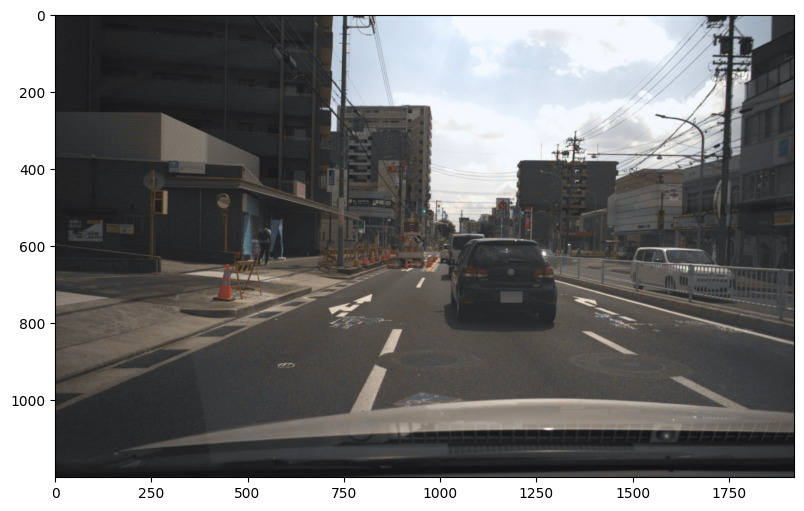

In [5]:
# 入力画像の確認
img = Image.open(cam_path)
plt.figure(figsize=(10, 6))
plt.imshow(img)

## セグメンテーションモデルの定義

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# 学習済みのdeeplabv3モデルをロード
model_seg = torch.hub.load('pytorch/vision:v0.6.0',
                           'deeplabv3_resnet101', pretrained=True)
model_seg.eval()
model_seg.to(device)

print("Segmentation Model Loaded.")

Using cuda device


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Segmentation Model Loaded.


## セグメンテーションモデルの推論

今回のモデルの推論で出力されるスコアは、次の3クラスです。

1. background
2. car
3. person

In [7]:
class_scores = get_segmentation_score(cam_path, model_seg, device)

print("class_scores shape: ", class_scores.shape)  # (H, W, C)

class_scores shape:  (1200, 1920, 3)


# 2. 融合 (点群のペインティング) 

セグメンテーションスコアを点群に投影し、点群の次元にセグメンテーションスコアを追加することで拡張点群を取得します。  
点群の次元は (x, y, z, r) から (x, y, z, r, C1, C2, C3) へ拡張されます。

In [8]:
# Lidar点群を画像に投影して画像座標を取得
points_mask, points_image = map_pointcloud_to_image(cam_path,
                                                    lidar_path,
                                                    cam_ego_pose,
                                                    lidar_ego_pose,
                                                    cam_calibration,
                                                    lidar_calibration)

print("points_mask", points_mask.shape)   # 画像範囲でマスク処理した点群 (N, pcd_dim)
print("points_image", points_image.shape) # (N, 2)  2:カメラ画像のx,y軸

points_mask (39581, 4)
points_image (39581, 2)


In [9]:
# 点群データとセグメンテーションを結合し、拡張点群データを作成
class_num = class_scores.shape[2]

# points_image は x,y が画像座標で、cols, rows であるのに対し、
# class_score は (rows, cols) なので、以下のインデックスの値は 1 → 0 と逆になる
point_scores = class_scores[points_image[:, 1], points_image[:, 0]]
point_scores = point_scores.reshape(-1, class_num)

print(point_scores.shape)  # (N, class_num)

(39581, 3)


In [10]:
painted_lidar = np.hstack([points_mask, point_scores])
painted_lidar = painted_lidar.astype(np.float32)

print(painted_lidar.shape)  # (N, pcd_dim + class_num)

(39581, 7)


## 可視化

### セグメンテーション + 画像

セグメンテーション結果を画像にオーバーラップして表示します。

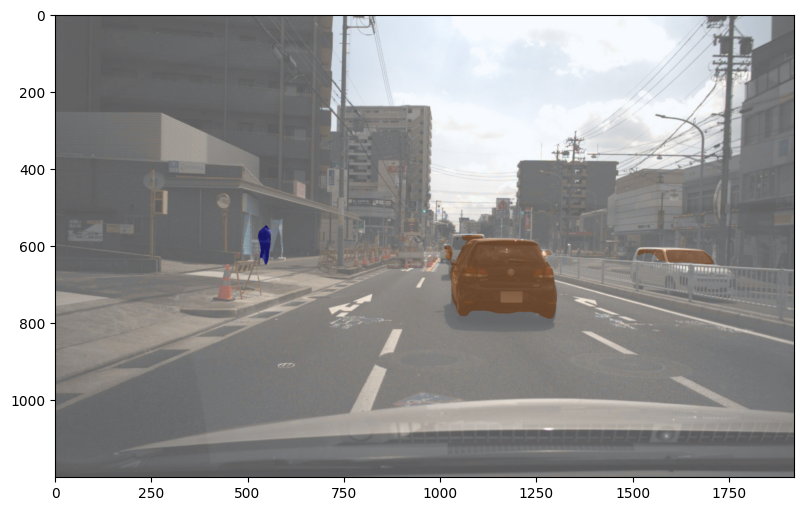

In [11]:
img = Image.open(cam_path)
img_np = np.array(img)

img_seg = overlap_seg(img_np,
                      class_scores,
                      opacity=0.3)

plt.figure(figsize=(10, 6))
plt.imshow(img_seg)

### セグメンテーション + 点群

点群とセグメンテーション結果を結合した拡張点群を3D散布図に表示します。

In [12]:
pc_data = painted_lidar[::4]  # 可視化処理の軽減のため1/4にデータ間引き

# 拡張点群のセグメンテーションの色
segcolor_dict = {0: "darkgray",  # background
                 1: "orange",    # car
                 2: "blue"}      # person

points_xyz = pc_data[:, :3]  # (x, y, z)を抽出
points_class = np.argmax(pc_data[:, 4:], axis=1)  # Classを抽出
points_colors = [segcolor_dict[i] for i in points_class]

fig = view_pointcloud(points_xyz, points_colors, mode="front")
fig.show()

# 3. 3D物体検出

拡張点群から3D物体検出を行います。

### 3D物体検出モデルの定義

In [13]:
model_detector = Second3DDector(config_path,
                                ckpt_path,
                                device=device)

[  41 1984  992]


In [14]:
pred_dict = model_detector.predict_on_points(painted_lidar)

print(pred_dict.keys())
print(pred_dict["boxes_lidar"].shape) # 3Dバウンディングボックス (N, 7)

# 3Dバウンディングボックスの推論結果
print(pred_dict["boxes_lidar"])    # [x, y, z, w, l, h, rz]
print(pred_dict["scores"])
print(pred_dict["label_preds"])    #  0: car, 1: pedestrian

dict_keys(['boxes_lidar', 'scores', 'label_preds'])
(4, 7)
[[11.212509   -0.58956355 -1.0905685   1.6928927   3.7969909   1.7684677
   1.5037142 ]
 [22.525883    8.26648    -0.25471312  0.55340743  0.7325267   1.6649815
   0.9995265 ]
 [18.733152   -7.026955   -1.3646964   1.7595533   4.1742835   1.6236844
  -1.5826242 ]
 [25.032644   -0.58383185 -0.8747587   1.8508015   4.6094227   1.7241998
   1.6356155 ]]
[0.8035167  0.6594634  0.6435181  0.58990395]
[0 1 0 0]


## 可視化

### カメラ画像

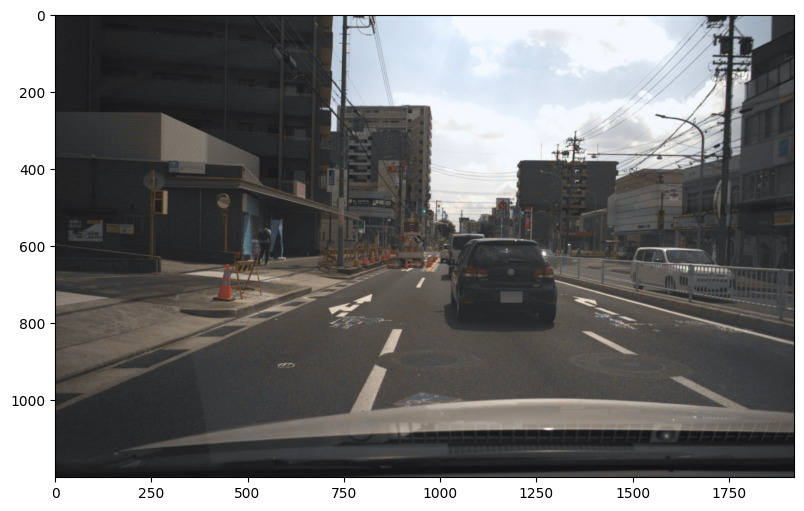

In [15]:
img = Image.open(cam_path)
plt.figure(figsize=(10, 6))
plt.imshow(img)

### 3Dバウンディングボックス + 画像

3Dバウンディングボックスを画像にオーバーラップして表示します。

In [16]:
# 3Dバウンディングボックスの各頂点座標を取得 (N, 7) -> (N, 8, 3)
box_corners = boxes_to_corners_3d(pred_dict["boxes_lidar"])
labels = pred_dict["label_preds"]

print(box_corners.shape) # 3DBBox各頂点のxyz座標 (N, 8, 3)

(4, 8, 3)


In [17]:
# Lidar座標系 -> カメラ座標系 に変換
box_corners_cam = lidar_to_cam(box_corners.reshape(-1, 3),
                        cam_ego_pose,
                        lidar_ego_pose,
                        cam_calibration,
                        lidar_calibration)

# 点群を画像へ投影し画像上の座標を取得
projection = np.array(cam_calibration['camera_intrinsic'])
box_corners_img = get_image_points(box_corners_cam[:, :3], projection) # (N, 3)

box_corners_img = box_corners_img[:, :2]             # (N * 8, 2)
box_corners_img = box_corners_img.reshape(-1, 8, 2)  # (N, 8, 2)

print(box_corners_img.shape)

(4, 8, 2)


In [18]:
name_list = model_detector.target_assigner.classes
label_name_dict = {i : name  for i, name in enumerate(name_list)}
print(label_name_dict)

{0: 'car', 1: 'pedestrian'}


In [19]:
color_dict_label = {0: (253, 141, 60),   # car:        orange
                    1: (0, 0, 255),      # pedestrian: blue    
                    }

box_colors = [color_dict_label[label] for label in labels]

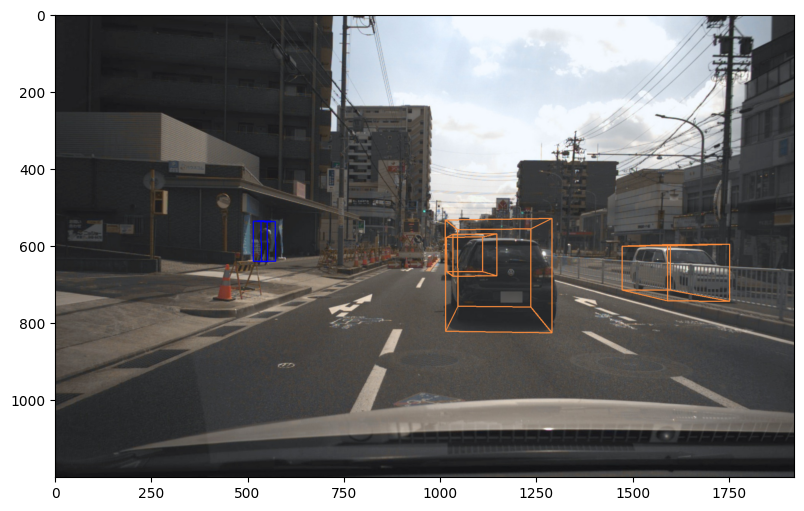

In [20]:
# 画像をOpenCVで読み込み
img_cv = cv2.imread(cam_path)
img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

# 3Dバウンディングボックス+画像を表示
img_cv_box = cv2_draw_3d_bbox(img_cv, box_corners_img,
                              box_colors, thickness=2, line_type=cv2.LINE_8)

plt.figure(figsize=(10, 6))
plt.imshow(img_cv_box)

### 3Dバウンディングボックス + 点群

点群と3Dバウンディングボックスを3D散布図に表示します。

In [21]:
# 点群
fig = view_pointcloud_3dbbox(points_xyz, points_colors, box_corners, box_colors)

fig.show()

# 推論結果を辞書形式に変換

3Dバウンディングボックスの推論結果を辞書形式に変換します。  
    （投稿ファイルの`predictor.py`のpredictメソッドの返り値と同じ形式です。）  

1. 3DバウンディングボックスをLidar座標からグローバル座標へ変換
2. 自車からの距離が指定範囲のものを検出対象とし、辞書形式に変換

In [22]:
# 3Dバウンディングボックスの中心座標 
points_box = pred_dict["boxes_lidar"][:, :3]  # (N, 3)  3: [x, y, z]

# Lidar座標系 -> グローバル座標系 に変換
points_box_global = lidar_to_global(points_box,
                                    lidar_ego_pose,
                                    lidar_calibration)

print(points_box_global.shape)   # (N, 3)

(4, 3)


In [23]:
list_pedestrian = []
list_vehicle = []

for pred, label, score in zip(points_box_global[:, :2],
                                pred_dict["label_preds"],
                                pred_dict["scores"].astype(np.float64)):
    # 自車からの距離
    dist = np.linalg.norm(pred - np.array(lidar_ego_pose['translation'][:2]))
    
    # 指定の距離以内を検出対象に加える
    if label_name_dict[label] == "pedestrian":
        if dist <= 40:
            list_pedestrian.append(list(pred) + [score])
    elif label_name_dict[label] == "car":
        if dist <= 50:
            list_vehicle.append(list(pred) + [score])

# 各カテゴリーの数を50以下に制限
list_pedestrian = list_pedestrian[:50]
list_vehicle = list_vehicle[:50]

prediction = {}
if len(list_pedestrian) > 0 :
    prediction["pedestrian"] = list_pedestrian
if len(list_vehicle) > 0 :
    prediction["vehicle"] = list_vehicle

output = {test_key: prediction}

print(output)

{'scene-0109_73': {'pedestrian': [[276.91187603898635, 217.77147925980503, 0.6594634056091309]], 'vehicle': [[265.2147438727587, 209.43238434979747, 0.803516685962677], [272.4416318387523, 202.6698378924808, 0.6435180902481079], [279.0219655722109, 208.82340773234571, 0.5899039506912231]]}}


以上